In [ ]:
direc = "...quant_test/quant_test/deribit"

# The Problem

In a setting similar to [2], [1] proposes to model the cumulative number of buy and sell orders faced by a market maker in the options market with Cox processes $Y_t^s$ and $Y_t^a$, respectively. In their model, the intensities of these Cox processes, also referred to as trading arrival intensities, take the form 
$$
\tag{1}\lambda^i(\delta)=A^i e^{-\kappa^i \delta},\ i\in\{a,b\}.
$$
Our goal is to estimate the parameters $A^i,\ \kappa^i,\ i=a,b$ from BTC options trade and quote data. 

Our approach is to estimate several state-dependent $\lambda^i$s, named $\hat\lambda^i(\delta_j),\ j=1,\dots,J,\ J\in\mathbb{N}$, and obtain the parameters of the model with a least-squares regression:

$$
\tag{2}
\arg_{\lambda_0^i,\kappa^i}\min \sum_{j=1}^J\left(\log\hat\lambda(\delta_j) -  \log A^i + \kappa^i \delta_j\right)^2.
$$

# Intensity estimation for Poisson processes

Let us forget about state dependence for a moment and just consider the estimation of the intensity $\lambda$ of a Poisson process $Y_t$ observed over the interval $[0,T]$. Let us refer to $0=t_0<t_1<\dots<t_N\le T$ as the arrival times of the jumps of the process, $Y_1,\dots,Y_N$ and to $\tau_i=t_i - t_{i-1},\ i=1,\dots,N$ as their waiting times. Two standard procedures to estimate $\lambda$ are:

- the Maximum Likelihood Estimator (MLE): $$\tag{3}\hat\lambda=\frac{N}{T},$$

- the Waiting Times Estimator (WTE): $$\tag{4}\bar\lambda= \frac{N}{\sum_{i=1}^N \tau_i}.$$

The MLE is unbiased, consistent, and efficient, whereas the WTE is biased but consistent. The bias in the WTE can be removed by using $N-1$ instead of $N$ in the numerator. 

# Introducing state dependence

[3] and [4] introduce state dependence in the intensity by fixing a reference price $P_t$ and considering the restricted Poisson processes 
$$Y_t^b(\delta)=\int_0^t\mathcal{1}_{\{Y_s^b\le P_s-\delta\}}dY^b_s\tag{5},$$
and
$$Y_t^a(\delta)=\int_0^t\mathcal{1}_{\{Y_s^a\ge P_s+\delta\}}dY^a_s\tag{6},$$
with intensities $\lambda^i(\delta),\ i=b,a$. 

Then, to estimate the parameters of the model $A_i,\ \kappa_i,\ i=b,a$ from discrete observations over $[0,T]$, the authors proceed as follows.
For each $\delta\in\{\delta_1,\dots,\delta_J\}$, they:
1. divide the interval $[0,T]$ into $N_T$ subintervals of equal length;
2. update the reference price within each subinterval using $$ P_t=P_{\left\lfloor \frac{N_Tt}{T} \right\rfloor\frac{T}{N_T}};$$
3. record the first waiting time, say $\hat\tau_i\in[(i-1)T/N_T, iT/N_T],i=1,\dots, N_T$;
4. obtain an estimate of $\lambda^i(\delta_j),\ i=b,a$ with the WTE in (3).
Finally, they run the linear regression in (2) to obtain the model parameters.

While [3] and [4] deal with stocks, we aim to estimate the same quantities for an out-of-the-money option, which is much less liquid. This makes the approach based on equally spaced subintervals problematic. 

# Loading and exploring the data

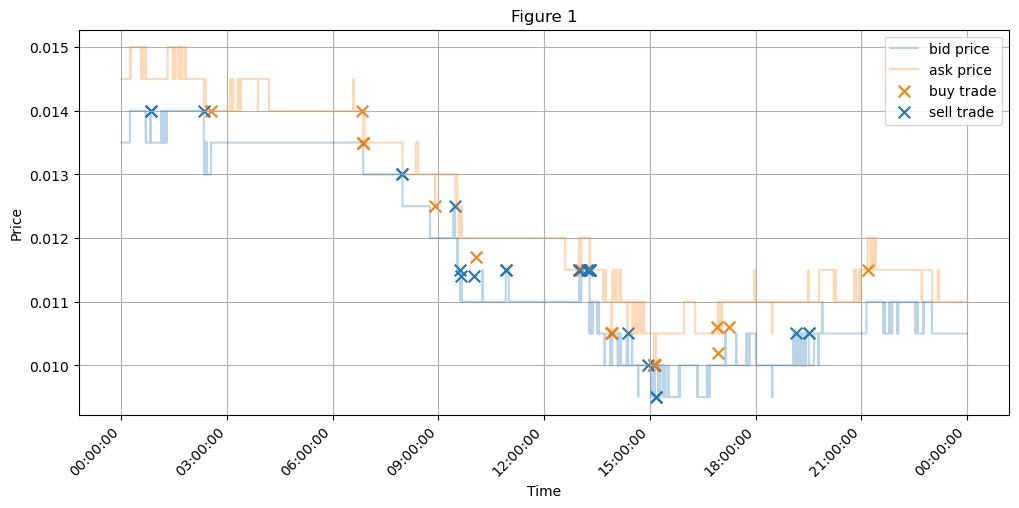

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
cbuy = '#ff7f0e'
csell = '#1f77b4'

# extract quotes data for BTC-27DEC24-100000
chunksize = 1_000_000
filtered_chunks = []
for chunk in pd.read_csv(
        direc + "/options_chain/2024-10-21_OPTIONS.csv.gz",
        compression='gzip',
        chunksize=chunksize):
    # filtering rows based on symbol
    mask = chunk['symbol'].str.contains("BTC-27DEC24-100000", na=False)
    filtered_chunk = chunk[mask]  
    if not filtered_chunk.empty:
        filtered_chunks.append(filtered_chunk)
df = pd.concat(filtered_chunks, ignore_index=True)
df.to_csv(direc + "/options_chain/2024-10-21_OPTIONS_filtered.csv")

# import trade data

df_trades = (
    pd.read_csv(
        direc + "/trades/2024-10-21_OPTIONS.csv.gz",
        compression='gzip',
        usecols=['symbol', 'timestamp', 'side', 'price', 'amount'],
        dtype={
            'symbol': 'category',
            'timestamp': 'int64',
            'local_timestamp': 'int64',
            'side': 'category',
            'price': 'float64',
            'amount': 'float32'
        }
    )
    .query('symbol.str.contains("BTC-27DEC24-100000")', engine='python')
    .drop(columns='symbol')
    .reset_index(drop=True)
    .sort_values("timestamp")
    .assign(datetime=lambda x: pd.to_datetime(x['timestamp'], unit='us', utc=True))
)

# import quote data

df_quotes = (
    pd.read_csv(
        direc + "/options_chain/2024-10-21_OPTIONS_filtered.csv",
        usecols=['symbol', 'timestamp', 
                 'bid_price', 'bid_amount', 'ask_price', 'ask_amount', 'mark_price'],
    )
    .query('symbol.str.contains("BTC-27DEC24-100000-C")', engine='python')
    .drop(columns=['symbol'])
    .sort_values("timestamp")
    .reset_index(drop=True)
    .assign(mid_price=lambda x: (x['bid_price'] + x['ask_price']) / 2)
    .assign(datetime=lambda x: pd.to_datetime(x['timestamp'], unit='us', utc=True))
    .rename(columns={'mid_price': 'ref_price'})
)

# plot trade and quote data

plt.figure(figsize=(12, 5))
plt.plot(df_quotes['datetime'], df_quotes['bid_price'], label='bid price', color=csell, alpha = 0.3)
plt.plot(df_quotes['datetime'], df_quotes['ask_price'], label='ask price', color=cbuy, alpha = 0.3)
for trade_side, color in zip(['buy', 'sell'], [cbuy, csell]):
    subset = df_trades[df_trades['side'] == trade_side]
    plt.scatter(subset['datetime'], subset['price'],
                color=color, s=70, alpha=1, marker='x', label=f'{trade_side} trade')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Figure 1')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.grid(True)
plt.show()

The data at our disposal to estimate the trading activity intensities, $\lambda^i(\delta),\ i=a,b$, are shown in Figure 1. These are quote and trade data on 21 October 2024 for a call option on BTC with strike price $K = 100,000$ and maturity 27 December 2024. Given that BTC was at $69,000$ at the opening of 21 October 2024, this option is far out of the money. 
Despite few anomalies, the order book data appear reasonable, as *buy trades* happen at the *ask price* and *sell trades* happen at the *bid price*. 
The option under consideration is quite illiquid, as we observe only 27 buy and 28 sell trades over the day. For this reason, we cannot follow the methodology in [3] and [4] for estimating $\lambda(\delta)^i,\ i=a,b$ by partitioning the daily interval into subintervals on the order of minutes and applying the WTE. In our case, we would have the vast majority of subinterval and reference price combinations without any trade, and this would still be true for wider windows. Therefore, we need to approach the problem differently. 
We propose two solutions:
- set extreme reference prices and estimate the intensities with the MLE over the whole day;
- use the WTE with mid quotes as reference prices, which are updated at each crossing time, i.e., a buy trade above $P_t+\delta$ or a sell trade below $P_t-\delta$. 

# MLE-based estimation

We start with the MLE-based approach.
For the buy side, we set time-independent $P_t=P_\text{min}^\text{buy}=\min(P_1^{\text{buy}},\dots,P_{27}^{\text{buy}})$ where $P_i^{\text{buy}},\ i=1,\dots,27$ are the prices of buy trades in our dataset. Then for $\delta_j=0,\dots, J\Delta$, we count how many buy trades occur above the inflated reference price $\{P^\text{buy}_t\ge P_t+\delta_j\}$, which is equivalent to considering the jumps of the restricted Poisson processes introduced in Equation (6), and calculate $\hat\lambda(\delta_j)$ by dividing this count by the length of the interval in hours, $T=24$. Similarly, for the sell side, we set $P_t=P_\text{max}^\text{sell}=\max(P_1^{\text{sell}},\dots,P_{27}^{\text{sell}})$, where $P_i^{\text{sell}},\ i=1,\dots,28$ are the prices of sell trades in our dataset, and consider the ratio between the count of events $\{P^\text{sell}_t\le P_t+\delta_j\}$ and $T=24$. In both cases, the counting happens in terms of the amount traded, i.e., a trade of 10 options is counted as 10 trades. Finally, for each side, we obtain the model parameters with the least-squares regression in (2).
We provide the implementation for $\Delta=0.0005$ and $J=8$ in the following together with comments.

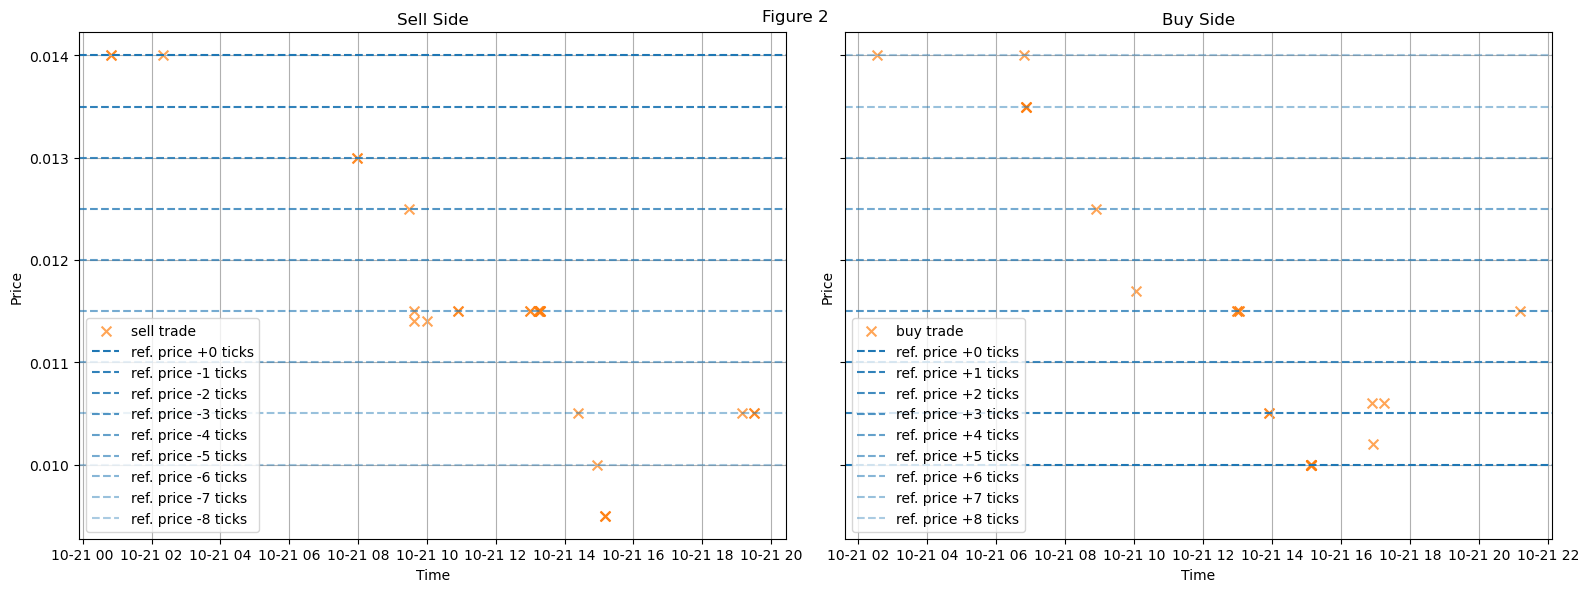

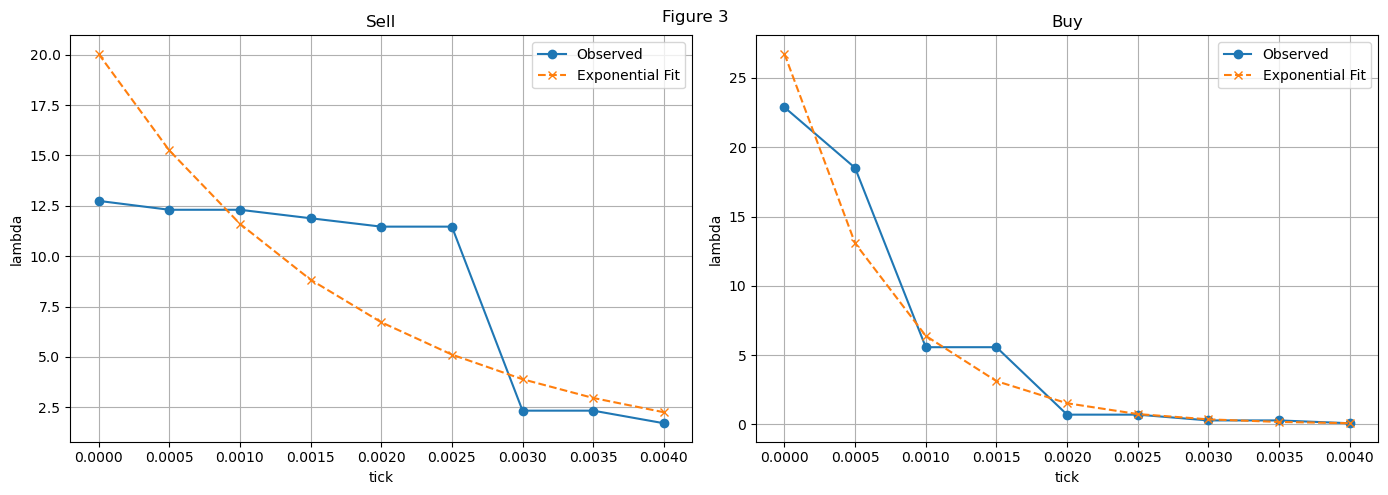

[Sell] A^b = 20.04, k^b = 546.25
[Buy] A^a = 26.74, k^a = 1431.73


In [54]:
# exponential regression functions

def exp_regr(x, z):
    y = np.log(z)
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return np.exp(intercept), slope

def fit_lambda(vd, llamb, ax=None, plot=True):
    A, b = exp_regr(vd, llamb)
    if plot:
        if ax is None:
            plt.figure(figsize=(8,5))
            ax = plt.gca()
            
        ax.plot(vd, llamb, marker='o', label='Observed')
        ax.plot(vd, A * np.exp(b * vd), color='#ff7f0e', marker='x', linestyle='--', label='Exponential Fit')
        ax.set_xlabel('tick')
        ax.set_ylabel('lambda')
        ax.legend()
        ax.grid(True)
    return A, - b

# MLE function

def est_mle(side, n_ticks, tick_size = None, plot = True, ax = None):
    # estimation
    sign = -1 if side == "sell" else 1
    prices = df_trades.loc[df_trades['side']==side, 'price'].to_numpy()
    amounts = df_trades.loc[df_trades['side']==side, 'amount'].to_numpy()
    if len(prices) == 0:
        return np.nan
    pmax, pmin = prices.max(), prices.min()
    if tick_size is None:
        tick_size = np.floor((pmax - pmin) / n_ticks * 10_000) / 10_000
    rp = pmax if side == "sell" else pmin
    ticks = np.arange(n_ticks + 1) * tick_size
    ev_matrix = ((rp + sign * ticks[:, None] >= prices) if side == "sell"
                 else (rp + sign * ticks[:, None] <= prices)).astype(int) * amounts
    intensity = ev_matrix.sum(axis=1) / 24 
    grid_tick = np.linspace(0, n_ticks, n_ticks + 1) * tick_size
    # plot
    if plot == True:
        if ax is None:
            plt.figure(figsize=(8,5))
            ax = plt.gca()
        subset = df_trades[df_trades['side'] == side]
        ax.scatter(subset['datetime'], subset['price'], label = side + " trade",
                    color='#ff7f0e', s=50, alpha=0.7, marker='x')
        for k in range(n_ticks + 1):
            level = rp + sign * k * tick_size
            alpha = 1 - (k / (n_ticks + 1) * 0.7)
            ax.axhline(level, color='#1f77b4', label = f"ref. price {sign * k:+d} ticks",
                        alpha=alpha, linewidth=1.5, ls = "--")
        ax.set_xlabel('Time')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True)
    return grid_tick, intensity

# fixed tick size

tick = 0.0005
nmax = 8

fig, axs = plt.subplots(1, 2, figsize=(16,6), sharey=True)
x_sell, l_sell = est_mle("sell", nmax, tick, plot=True, ax=axs[0])
axs[0].set_title('Sell Side')
x_buy, l_buy = est_mle("buy", nmax, tick, plot=True, ax=axs[1])
axs[1].set_title('Buy Side')
plt.tight_layout()
fig.suptitle('Figure 2')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(14,5))
A_sell, k_sell = fit_lambda(x_sell, l_sell, ax=axs[0])
axs[0].set_title('Sell')
A_buy, k_buy = fit_lambda(x_buy, l_buy, ax=axs[1])
axs[1].set_title('Buy')
plt.tight_layout()
fig.suptitle('Figure 3')
plt.show()

print("[Sell] A^b = " + str(round(A_sell, 2)) + ", k^b = " + str(round(k_sell, 2)))
print("[Buy] A^a = " + str(round(A_buy, 2)) + ", k^a = " + str(round(k_buy, 2)))

Figure 2 shows the counting methodology in action. We start with an extreme reference price and the top (bottom) of the book for sell (buy) orders, count how many trades occur below (above) this threshold, and obtain $\lambda(0)$ by dividing this count by $T=24$ (MLE). We then update the threshold by subtracting (adding) one tick from the reference price, count how many trades occur below (above) this new threshold, and calculate the new $\lambda(\Delta)$ by dividing this count by $T=24$. This procedure is repeated $J=8$ times in total for each side of the book, yielding $\hat\lambda^i(\delta_j),j=1,\dots,J, i = \text{a,b}$, where $a$ ($b$) stands for ask (bid) and corresponds to the buy (sell) trades in the book. Each trade (orange cross) corresponds to a certain number of options; we account for this by counting each trade as many times as the order amount.

The estimated $\hat\lambda^i(\delta_j),j=1,\dots,J, i = \text{a,b}$ are shown in Figure 3 in blue, together with their best exponential fits in orange. The resulting fit is very accurate for buy trades ($a$) but less so for sell trades ($b$). This is due to the illiquidity of the option under consideration, for which most sell trades occur at the sixth threshold (cf. Figure 2). The estimated parameters with the least-squares regression for buy and sell trades, respectively, are $A^a = 26.74,\ \kappa^a = 1431.73$ and $A^b = 20.04,\ \kappa^b = 546.25$ .

We now repeat this procedure for different tick sizes 
$$
\Delta^i=\lfloor(P_\text{max}^i - P_\text{min}^i)/J\rfloor,\ \ J\in\{2,4,8,16,32\},\ i=a,b
$$ 
and record $A^i, \kappa^i,\ i=a,b$ to analyze the stability of the model. This was done before fixing $\Delta=0.0005$ and $J=8$, which were eventually chosen because of stability and because $\Delta=0.0005$ appears to be the minimum tick size in our limit-order-book data.

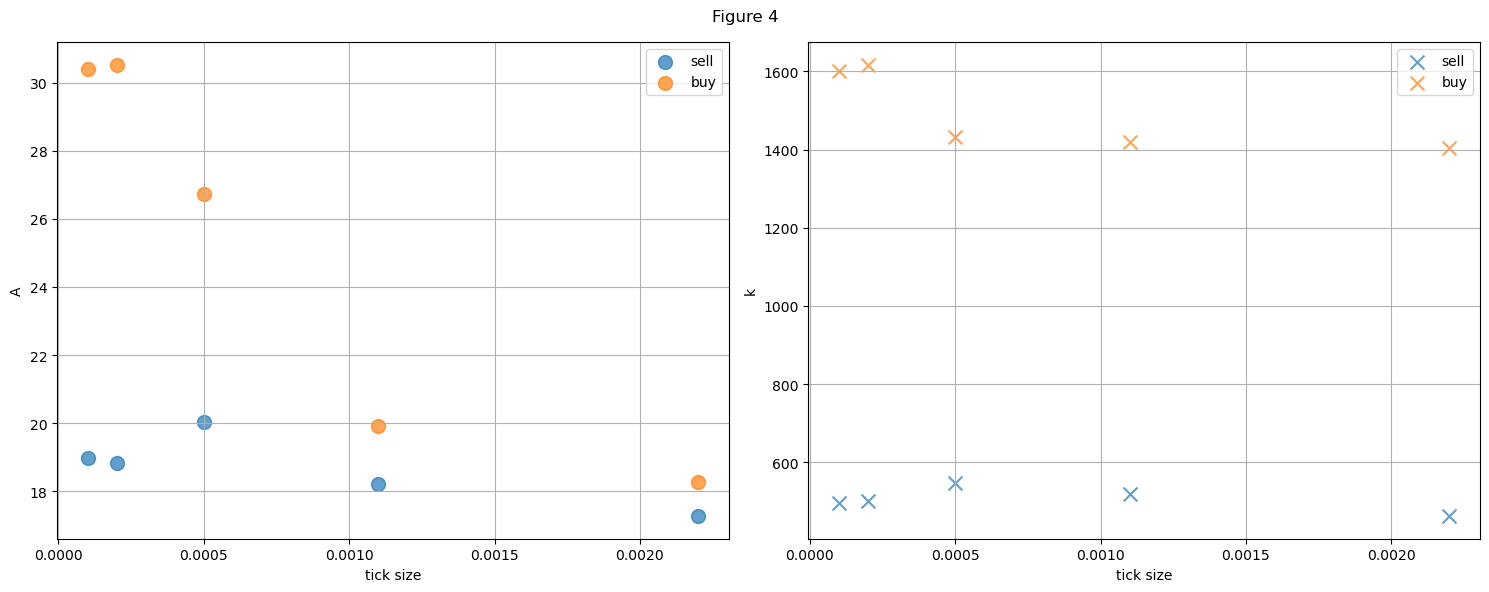

In [55]:
# stability analysis

vmt = [2, 4, 8, 16, 32]
vAb = []
vkb = []
vAs = []
vks = []
vts = []
for i in range(len(vmt)):
    x, y = est_mle("buy", vmt[i], plot = False)
    A, b = exp_regr(x, y)
    vAb.append(A)
    vkb.append(- b)
    x, y = est_mle("sell", vmt[i], plot = False)
    A, b = exp_regr(x, y)
    vAs.append(A)
    vks.append(- b)
    vts.append(x[1] - x[0])
    
fig, ax = plt.subplots(1, 2, figsize=(15, 6))  
ax[0].scatter(vts, vAs, color=csell, s=100,  alpha=0.7, label = "sell")
ax[0].scatter(vts, vAb, color=cbuy, s=100,  alpha=0.7, label = "buy")
ax[0].set_xlabel('tick size')
ax[0].set_ylabel('A')
ax[0].grid(True)
ax[0].legend()
ax[1].scatter(vts, vks, color=csell, s=100, marker='x', alpha=0.7, label = "sell")
ax[1].scatter(vts, vkb, color=cbuy, s=100, marker='x', alpha=0.7, label = "buy")
ax[1].set_xlabel('tick size')
ax[1].set_ylabel('k')
ax[1].grid(True)
ax[1].legend()
fig.suptitle('Figure 4')
plt.tight_layout()
plt.show()

Figure 4 shows the calibrated parameters $A^i,\ \kappa^i,\ i=a\ \text{(buy)},b\ \text{(sell)}$ on the grid $J=2,4,8,16,32$ as explained above. The values for $\kappa^i$ are quite stable overall, while those of $A^i$ differ for small or large tick sizes. 

# WTE-based estimation

We now focus on a WTE-based approach, similar to that in [3] and [4]. As in [3] and [4], we consider the inverse of the average waiting time. However, instead of partitioning the interval $[0, T]$ ex ante, we initiate a new interval and update the reference price to the prevailing mid-quote whenever a trade occurs. In what follows, we show the implementation only for sell trades. As will become clear, this dataset does not allow the same procedure to be applied to buy trades. We fix $\Delta=0.0005$ and $J=3$. 

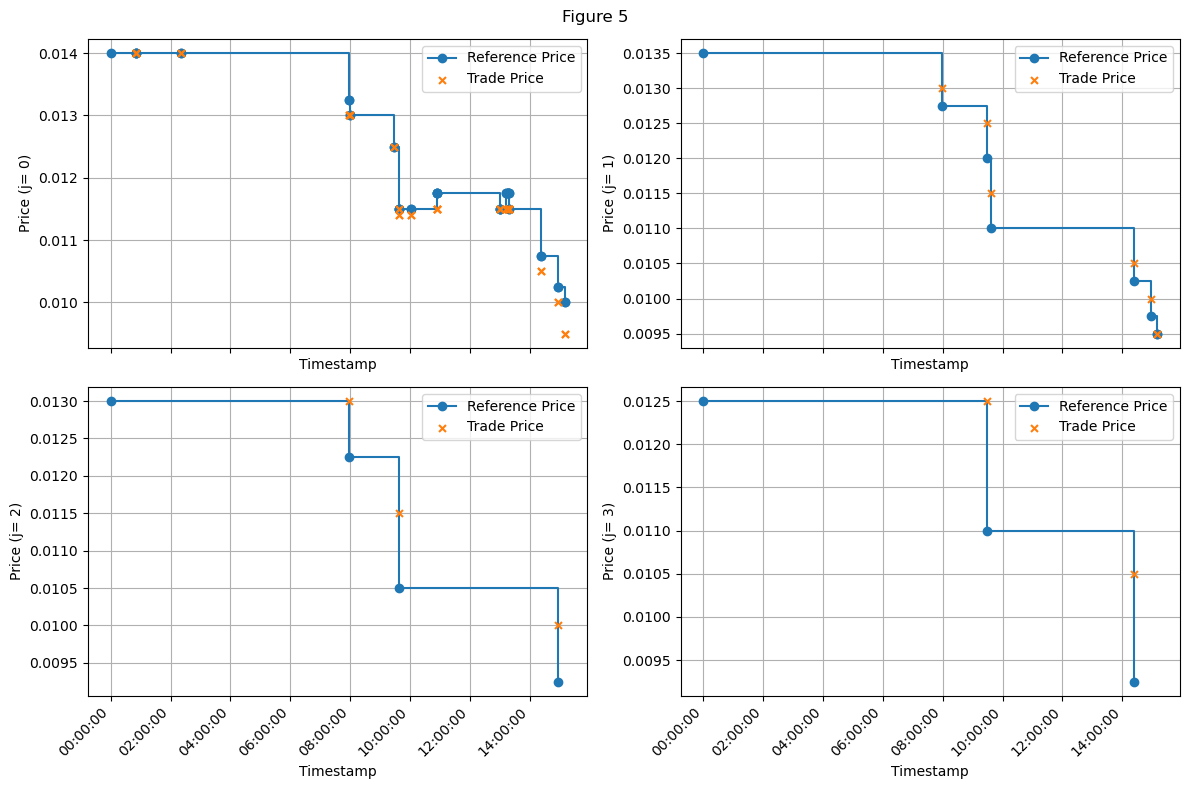

In [56]:
# merge trades and midquotes

df_ref = df_quotes[['timestamp', 'ref_price']].copy()
df_all = (
    pd.merge_asof(
        df_trades.sort_values('timestamp'),
        df_ref.sort_values('timestamp'),
        on='timestamp',
        direction='nearest'
    )
    .query("side == 'sell'")
    [['timestamp', 'price', 'amount', 'ref_price', 'datetime']]
    .reset_index(drop=True))

# WTE sell side

tsize = 0.0005
maxtick = 3
llambda = []
ncols = 2
nrows = int(np.ceil((maxtick + 1)/2))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8), sharex=True)
axes = axes.flatten()
for k in range(maxtick + 1):
    vt = []
    vrp = []
    vtp = []
    vtau = []
    va = []
    vdt = []
    vt.append(df_quotes['timestamp'][0])
    vdt.append(df_quotes['datetime'][0])
    p0 = df_quotes['ref_price'][0]
    vrp.append(p0 - k * tsize)

    i = 0
    btrades = df_all['price'] <= vrp[i]
    while btrades.any():
        idx = btrades[btrades].index[0]
        vtp.append(df_all['price'][idx])
        vt.append(df_all['timestamp'][idx])
        vdt.append(df_all['datetime'][idx])
        vtau.append((vt[i + 1] - vt[i]) / (1_000_000 * 60 * 60)) # hours
        va.append(df_all['amount'][idx])
        vrp.append(df_all['ref_price'][idx] - k * tsize)
        btrades = df_all[df_all['timestamp'] > vt[i]]['price'] <= vrp[i + 1]
        i += 1
    llambda.append(sum(va) / sum(vtau[i] * va[i] for i in range(len(vtau))))
    
    ax = axes[k]
    ax.plot(vdt, vrp, drawstyle='steps-post', label='Reference Price', marker='o')
    ax.scatter(vdt[1:], vtp, color='#ff7f0e', label='Trade Price', marker = 'x', s=25, zorder=5)
    ax.set_ylabel(f'Price (j= {k})')
    ax.grid(True)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_xlabel('Timestamp')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
fig.suptitle('Figure 5')
plt.tight_layout()
plt.show()

The subplots in Figure 5 show the counting procedure for $P_t+j\Delta, j = 0,1,2,3$. Let us focus on the first plot $(j=0)$. We set $P_t$ equal to the mid-quote and wait until a sell trade happens at or above $P_t$ (orange cross). This happens within the first hour. At this point, we record the elapsed time, $\tau_1$, and refresh the reference price to be the mid-quote prevailing at $\tau_1$, $P_t=P_{\tau_1}$. When a new trade occurs at or above the new reference price, we record $\tau_2=t-\tau_1$ and update the reference price again to the prevailing mid-quote. We repeat this procedure until no further trades occur at or above the reference price. In Figure 5, this happens around 15:00:00. 

Using this procedure, we obtain several waiting times $\tau_i,i=1,\dots, N_\tau$ which we multiply by the amounts of the corresponding trades, average, and take the reciprocal to obtain $\bar\lambda^b(0)$. We repeat this process for $j=1,2,3$ and plot the results in the following figure, together with the best exponential fit. Notice that this procedure cannot be applied to this dataset for buy trades. As shown in Figure 1, the buy prices during the first half of the day are almost monotonically decreasing, making it difficult to set an initial reference price that allows for trades at a higher price.

A = 3.8702073462381095, k = 2266.387163571486


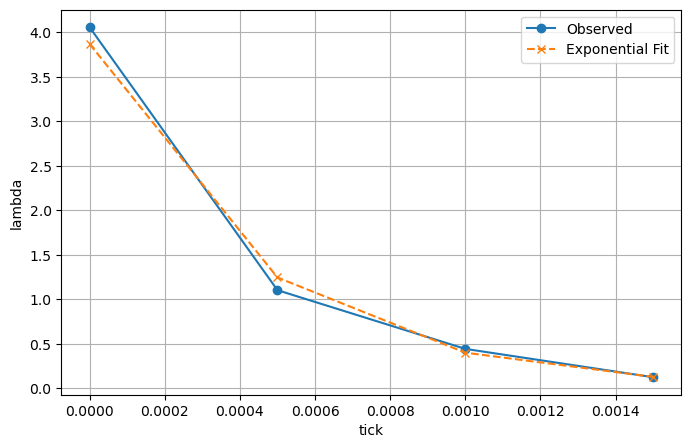

In [57]:
# exponential fit

vd = np.linspace(0, maxtick, maxtick + 1) * tsize  
A, k = fit_lambda(vd, llambda)
print("A = " + str(A) + ", k = " + str(k))

The results in the figure above suggest more moderate intensities $\lambda^b(\delta_j),j=0,1,2,3$ than those obtained with the previous procedure, which are accurately described by an exponential law. Consequently, the constant $A^b=3.87$ is estimated lower than before, but the elasticity $\kappa^b=2266$ is estimated higher. 

We conclude that these sparse trades make it difficult to obtain reliable estimates for the model parameters for this out-of-the-money option. Extreme constant reference prices are easy to implement and yield high intensities by accounting for all the trades. Frequently updated reference prices, which more accurately capture changing circumstances over the day, deliver more moderate intensities; however, they would require either more data to fix subintervals ex-ante or more variability to be used. However, the generally high values of $\kappa$ suggest that slight changes in the spread might result in wide changes in trade activity for this instrument.

# Estimates across the moneyness range (bonus task)

So far, we have focused on a single call option with strike price $K=100{,}000$ on 21 October 2024. We now consider on the same day all available BTC call options with the same maturity, estimate values for $\kappa^i,\ i=a,b$, and try to understand how these quantities relate to moneyness, $m=K/\bar S$. We consider moneyness with respect to the average BTC value during the whole day, $\bar S=69{,}345$. 

For this task, we are not provided with trade data and therefore try to estimate the trades from quote data. Quote data includes the variables 'timestamp', 'type', 'strike_price', 'last_price', 'bid_price', 'bid_amount', 'ask_price', and 'ask_amount'. We record a trade at a given 'timestamp' when the variable 'last_price' changes in the immediately following 'timestamp'. We infer the trade direction by comparing the new 'last_price' to the 'ask_price' (buy trade) or 'bid_price' (sell trade) at the original 'timestamp'. Unfortunately, from this data, we are not able to infer the size of the trades. 

The estimation methodology we employ is the MLE-based approach outlined above, where we fix $J=1$ and fit the functional form in (1) using only $\lambda^i(0)$ and $\lambda^i(\Delta)$, $i=a,b$, where $\Delta$ defined as the mid-point between the minimum and maximum trade prices. This choice is driven by the overall low liquidity of these call options and by our goal of computing $\kappa^i,\ i=a,b$ for as many strikes as possible. Fitting the exponential on two intensity points is also suggested in [4], which introduces regression on additional points only for robustness. We now illustrate market liquidity and present the estimates.

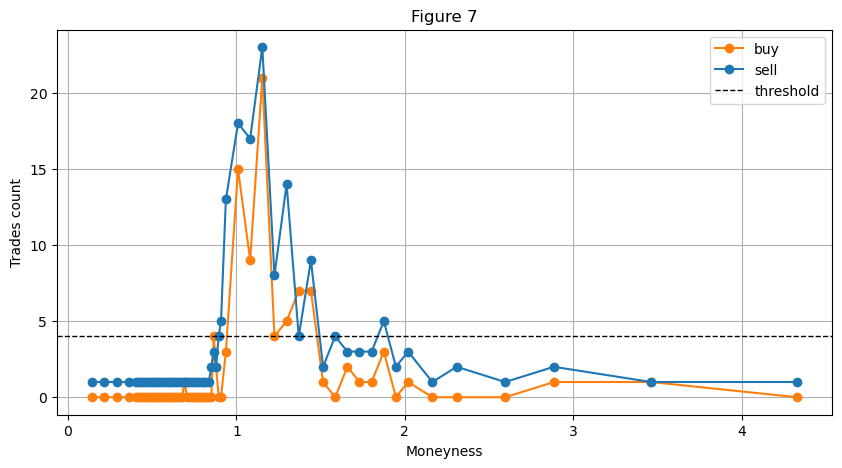

In [58]:
filtered_chunks = []
colnames = ['symbol', 'timestamp', 'type', 'strike_price', 'last_price',
    'bid_price', 'bid_amount', 'ask_price', 'ask_amount', 'underlying_price']
for chunk in pd.read_csv(
        direc + "/options_chain/2024-10-21_OPTIONS.csv.gz",
        compression='gzip',
        chunksize=chunksize,
        usecols = colnames
    ):
    mask = chunk['symbol'].str.contains("BTC-27DEC24-", na=False)
    filtered_chunk = chunk[mask]
    if not filtered_chunk.empty:
        filtered_chunks.append(filtered_chunk)
df_smile = pd.concat(filtered_chunks, ignore_index=True)
df_smile.to_csv(direc + "/options_chain/2024-10-21_OPTIONS_smile.csv")

df_smile = pd.read_csv(direc + "/options_chain/2024-10-21_OPTIONS_smile.csv")
und_price = df_smile['underlying_price'].mean()

# estimating function

def est_k(df_trades, side, n_ticks=4):
    sign = -1 if side == "sell" else 1
    prices = df_trades.loc[df_trades['side']==side, 'price'].to_numpy()
    if len(prices) == 0:
        return np.nan
    pmax, pmin = prices.max(), prices.min()
    tick_size = np.floor((pmax - pmin) / n_ticks * 10_000) / 10_000
    rp = pmax if side == "sell" else pmin
    ticks = np.arange(n_ticks + 1) * tick_size
    ev_matrix = ((rp + sign * ticks[:, None] >= prices) if side == "sell"
                 else (rp + sign * ticks[:, None] <= prices)).astype(int)
    
    z = ev_matrix.sum(axis=1) / 24 
    x = ticks
    y = np.log(z)
    w = len(x)
    slope = (w * np.sum(x*y) - np.sum(x)*np.sum(y)) / (w * np.sum(x**2) - (np.sum(x))**2)
    return - slope

# grid

df_grid = (
    df_smile.assign(
        strike_price = df_smile['symbol'].str.extract(r'-(\d+)-')[0].astype(int),
        type = df_smile['symbol'].str.extract(r'-(C|P)$')[0],
        moneyness = lambda d: d['strike_price'] / und_price
    )
    .drop_duplicates(['strike_price', 'moneyness', 'type'])
    .pivot_table(index=['strike_price','moneyness'], columns='type', 
                 values='symbol', aggfunc='count', fill_value=0)
    .rename(columns={'C':'call','P':'put'})
    .reset_index()
)

# liquidity and estimates loop

opt_type = "C"
df_k = df_grid[['moneyness', 'strike_price']].copy()
df_k['buy'] = np.nan
df_k['sell'] = np.nan
nmax = 1
trades_min = 4

df_n = df_grid[['moneyness', 'strike_price']].copy()
df_n['buy'] = np.nan
df_n['sell'] = np.nan
for i in range(df_grid.shape[0]):
    
    # estimate trades
    
    strike = df_grid.loc[i, "strike_price"]
    symbol_str = f"BTC-27DEC24-{strike}-{opt_type}"
    tmp = (
           df_smile
           .query("symbol == @symbol_str")
           .sort_values("timestamp")
           .reset_index(drop = True)
           .drop(["symbol", "type", "strike_price", "underlying_price"], axis = 1)
           )
    tmp["trade"] = (tmp["last_price"].shift(-1) != tmp["last_price"]).fillna(False).astype(int)
    idx_trade = tmp["trade"] == 1
    tmp["dask"] =  (tmp["ask_price"] - tmp["last_price"].shift(-1))**2
    tmp["dbid"] =  (tmp["bid_price"] - tmp["last_price"].shift(-1))**2
    
    # count trades
    
    labels = np.where(tmp.loc[idx_trade, "dask"] < tmp.loc[idx_trade, "dbid"], "buy", "sell")
    labels, count = np.unique(labels, return_counts=True)
    counts_dict = {"buy": 0, "sell": 0}
    counts_dict.update(dict(zip(labels, count)))
    df_n.loc[i, ["buy", "sell"]] = counts_dict['buy'], counts_dict['sell']
    
    # estimate kappa 
    
    tmp.loc[idx_trade, "side"] = np.where(
        tmp.loc[idx_trade, "dask"] < tmp.loc[idx_trade, "dbid"],
        "buy", "sell")
    foo = tmp.loc[idx_trade, ["timestamp", "side", "ask_price", "bid_price"]].reset_index(drop = True)
    foo["price"] = np.where(foo["side"] == "buy", foo["ask_price"], foo["bid_price"])
    df_trades = foo[["timestamp", "side", "price"]]

    if (df_trades['side'] == 'buy').sum() >= trades_min:
        df_k.loc[i, 'buy'] = est_k(df_trades, "buy", n_ticks=nmax)
        
    if (df_trades['side'] == 'sell').sum() >= trades_min:
        df_k.loc[i, 'sell'] = est_k(df_trades, "sell", n_ticks=nmax)

# plot liquidity (# trades)

plt.figure(figsize=(10,5))
plt.plot(df_n['moneyness'], df_n['buy'], marker='o', linestyle='-', color=cbuy, label='buy')
plt.plot(df_n['moneyness'], df_n['sell'], marker='o', linestyle='-', color=csell, label='sell')
plt.axhline(y=4, color='black', linestyle='--', linewidth=1, label = 'threshold')
plt.xlabel('Moneyness')
plt.ylabel('Trades count')
plt.legend()
plt.grid(True)
plt.title('Figure 7')
plt.show()

Figure 7 presents the number of estimated trades over the whole day for all observed moneyness levels of call options with maturity 27 December 2024. Buy and sell trades occur in roughly similar amounts, with buy trades being slightly fewer than sell trades. The majority of trades happen at the money or slightly out of the money. The estimated numbers are comparable to the number of trades for the call option with strike $K=100{,}000$ analyzed earlier, again reflecting low liquidity. However, this call option now shows fewer trades. This is a consequence of the fact that these trade data are estimated rather than observed. We fit the model using the MLE-based methodology combined with the regression, applied separately to each side of the book whenever it contains at least four trades (threshold), and present the results in the figure below.

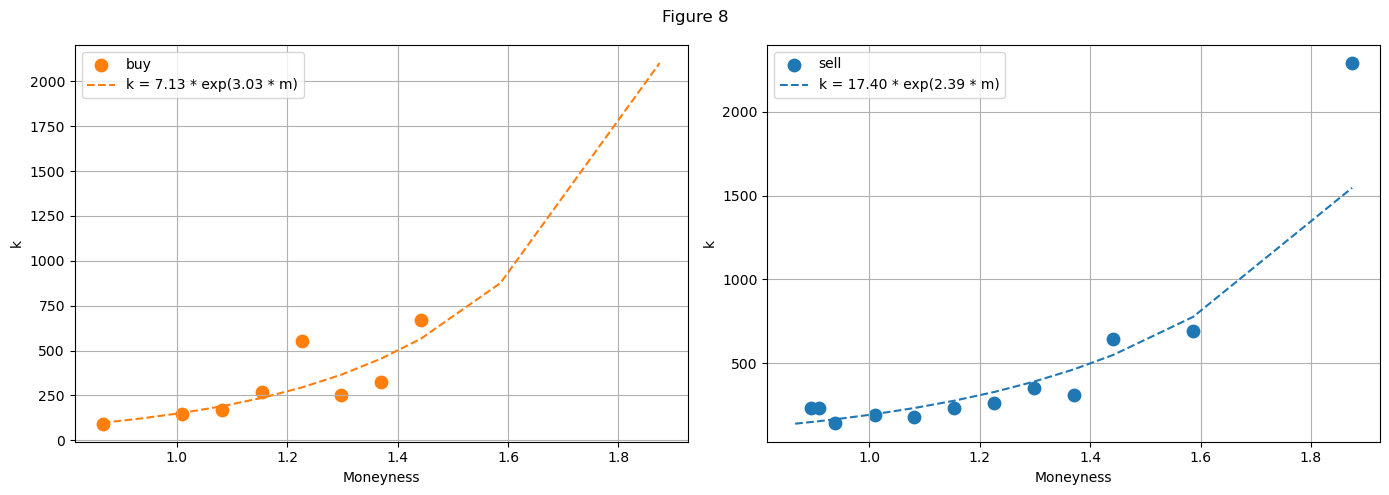

In [59]:
# plot kappa estimates and exponential fit

df_plot = df_k.dropna(subset=['buy', 'sell'], how='all').reset_index(drop = True)
idxb = df_plot['buy'].notna()
idxs = df_plot['sell'].notna()
Ab, bb = exp_regr(df_plot['moneyness'][idxb], df_plot['buy'][idxb])
As, bs = exp_regr(df_plot['moneyness'][idxs], df_plot['sell'][idxs])
vx = df_plot['moneyness']
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharex=True)
fig.suptitle('Figure 8')
axes[0].scatter(vx[idxb], df_plot.loc[idxb, 'buy'], color=cbuy, s=80, label='buy')
axes[0].plot(vx, Ab * np.exp(bb * vx), color=cbuy, linestyle='--',
             label=f"k = {Ab:.2f} * exp({bb:.2f} * m)")
axes[0].set_xlabel('Moneyness')
axes[0].set_ylabel('k')
axes[0].legend()
axes[0].grid(True)
axes[1].scatter(vx[idxs], df_plot.loc[idxs, 'sell'], color=csell, s=80, label='sell')
axes[1].plot(vx, As * np.exp(bs * vx), color=csell, linestyle='--',
             label=f"k = {As:.2f} * exp({bs:.2f} * m)")
axes[1].set_xlabel('Moneyness')
axes[1].set_ylabel('k')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

Figure 8 presents the estimates of the parameters $\kappa^i,\ i=a,b$ for the set of moneyness levels displaying at least four trades. The results agree for $K=100{,}000$ with the previous MLE-based estimate on sell (recorded) trades, as both are around $k^{b}=600$, but do not agree in terms of buy trades. 

However, the $\kappa^i$ values are clearly increasing with moneyness, and their shapes are well captured by exponential laws. We can therefore conclude that the elasticity of demand and supply is higher for more out-of-the-money call options. 

It would also be interesting to analyze put options and develop an estimation methodology better suited for these products, which are characterized by few trades.

# References <!-- no-number -->

[1] Lucic, Vladimir, and Alex SL Tse. "Optimal Option Market Making and Volatility Arbitrage." *Available at SSRN 4729290* (2024).

[2] Avellaneda, Marco, and Sasha Stoikov. "High-frequency trading in a limit order book." Quantitative Finance 8.3 (2008): 217-224.

[3] Tapia, Joaquin Fernandez. Modeling, optimization and estimation for the on-line control of trading algorithms in limit-order markets. Diss. Université Pierre et Marie Curie-Paris VI, 2015.

[4] Laruelle, S. "Faisabilité de l’apprentissage des paramètres d’un algorithme de trading sur des données réelles’." Hors-Série Microstructure des Marchés 1 (2013): 1-25.